In [31]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch

from src import datasets, metrics

In [32]:
import tomllib

datadir = Path('../data')
configfile = Path("config.toml")

with configfile.open('rb') as f:
    config = tomllib.load(f)
print(config)

{'ptb': 'heart', 'arrhythmia': 'heart_big'}


In [33]:
trainfile = datadir / (config['arrhythmia'] + '_train.parq')
testfile = datadir / (config['arrhythmia'] + '_test.parq')
trainfile, testfile

(PosixPath('../data/heart_big_train.parq'),
 PosixPath('../data/heart_big_test.parq'))

Get the 1D data into a 2D matrix

In [34]:
shape = (16, 12)
traindataset = datasets.HeartDataset2D(trainfile, target="target", shape=shape)
testdataset = datasets.HeartDataset2D(testfile, target="target", shape=shape)
traindataset, testdataset
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS")
else:
    device = "cpu"

traindataset.to(device)
testdataset.to(device)


Using MPS


Let's see how that works. 
Compare this to the 1D data to see if you understand the transformation.

(torch.Size([1, 16, 12]), tensor(0, device='mps:0'))

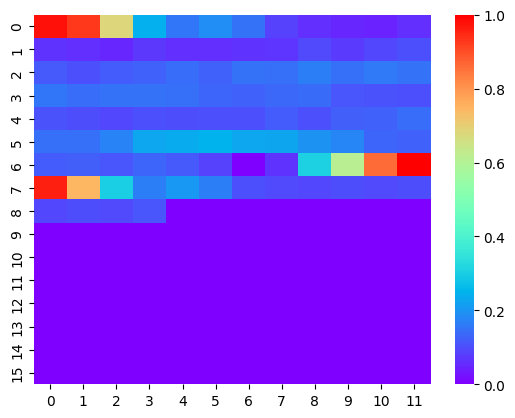

In [35]:
x, y = traindataset[0]
# Assuming your tensor is named 'tensor'
viz = x.squeeze().cpu().numpy()
sns.heatmap(viz, cmap='rainbow')
x.shape, y

Load into a streamer

In [36]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
len(trainstreamer), len(teststreamer)

(2736, 684)

In [37]:
x, y = next(trainstreamer.stream())
x.shape, y.shape

(torch.Size([32, 1, 16, 12]), torch.Size([32]))

The ConvBlock makes it easier to stack block in the model.
Feel free to experiment with other architectures here:
- adding ideas like resnet, googlenet, squeeze-excite, etc.
- add additional layers like dropout, batchnorm, etc.
- experiment with different ways to go from 4D to 2D tensors

In [38]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.conv(x)

In [39]:
import torch
class CNN(nn.Module):
    def __init__(self, config: dict) -> None:
        super().__init__()
        hidden = config['hidden']
        self.convolutions = nn.ModuleList([
            ConvBlock(1, hidden),
        ])

        for i in range(config['num_blocks']):
            self.convolutions.extend([ConvBlock(hidden, hidden), nn.ReLU()])
        self.convolutions.append(nn.MaxPool2d(2, 2))

        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.1),  # Dropout before first dense layer
            nn.Linear((8*6) * hidden, hidden),
            nn.ReLU(),
            nn.Dropout(0.1),  # Dropout before final output
            nn.Linear(hidden, config['num_classes']),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for conv in self.convolutions:
            x = conv(x)
        x = self.dense(x)
        return x

In [40]:
from src import models

config = {
    'hidden': 128,
    'num_blocks': 1,
    'num_classes': 5,
    'shape': shape,
}

model = models.CNN(config)
model.to(device)
model(x).shape


2025-01-23 15:00:08.267 | INFO     | src.models:__init__:37 - Activation map size: 48
2025-01-23 15:00:08.270 | INFO     | src.models:__init__:38 - Input linear: 6144


torch.Size([32, 5])

In [41]:
yhat = model(x)

The data is unbalanced, so we are interested in much more than just accuracy.

In [42]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

In [43]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment("2D conv model")

<Experiment: artifact_location='/Users/rubengoedings/Documents/Ru_hu_ML_exam/notebooks/mlruns/4', creation_time=1737640483863, experiment_id='4', last_update_time=1737640483863, lifecycle_stage='active', name='2D conv model + dropout', tags={}>

In [44]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=5,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2D",
        train_steps=len(trainstreamer) // 5,
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    # modify the tags when you change them!
    mlflow.set_tag("model", "Conv2D + dropout")
    mlflow.set_tag("dataset", "heart_big")
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")

    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("shape0", shape[0])
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_params(settings.optimizer_kwargs)

    mlflow.log_param("dropout_rate", 0.1)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=None,
        )
    trainer.loop()


2025-01-23 15:00:08.482 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2D/20250123-150008
  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 547/547 [00:06<00:00, 85.31it/s]
2025-01-23 15:00:15.690 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.3334 test 0.1835 metric ['0.9557', '0.9557', '0.8007', '0.9557', '0.8236']
100%|██████████| 547/547 [00:06<00:00, 90.23it/s]
2025-01-23 15:00:22.561 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.1428 test 0.1745 metric ['0.9497', '0.9497', '0.7874', '0.9497', '0.7825']
100%|██████████| 547/547 [00:06<00:00, 89.39it/s]
2025-01-23 15:00:29.479 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.1148 test 0.1043 metric ['0.9724', '0.9724', '0.8659', '0.9724', '0.8678']
100%|██████████| 547/547 [00:06<00:00, 89.22it/s]
2025-01-23 15:00:36.395 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.1072 test 0.1109 metric ['0.9722', '0.9722', '0.8653', '0.9722', '0.8710']
100%|██████████| 547/547 [00:06<00:00, 90.46it/s]
2025-01-23 15:00:43.248 | INFO     | mltrainer.trainer:report:191 - Epoch 4 train 0.0939 test 0.0910 metric ['0.97

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

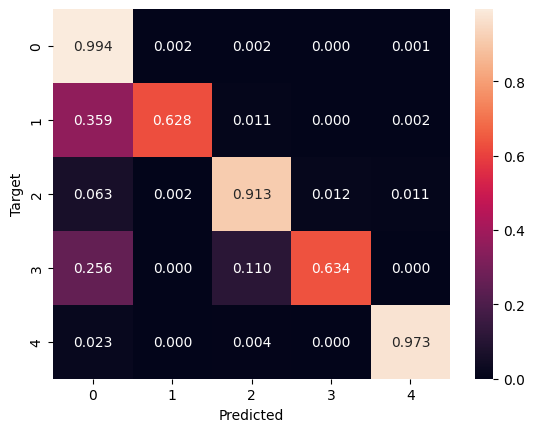

In [45]:
import seaborn as sns
import numpy as np

y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")